In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import warnings
warnings.filterwarnings('ignore')

In [23]:
class GreyModelGM11:
    """
    Complete implementation of Grey Prediction Model GM(1,1)
    """
   
    def __init__(self):
        self.original_data = None # Original data
        self.accumulated_data = None # Accumulated data
        self.a = None # Development coefficient
        self.b = None # Grey action quantity
        self.fitted_values = None # Fitted values
        self.errors = None # Errors
        self.predictions = None # Predictions
       
    def fit(self, data):
        """
        Fit GM(1,1) model
       
        Parameters:
            data: One-dimensional array, original data sequence
        """
        self.original_data = np.array(data, dtype=np.float64)
        n = len(data)
       
        # 1. Data validation
        if np.any(self.original_data < 0):
            print("Warning: Data contains negative values, translation processing will be performed")
            min_val = np.min(self.original_data)
            self.original_data = self.original_data - min_val + 1
       
        # 2. Accumulate generation (AGO)
        self.accumulated_data = np.cumsum(self.original_data)
       
        # 3. Construct background value sequence
        Z = np.zeros(n-1)
        for i in range(1, n):
            Z[i-1] = 0.5 * (self.accumulated_data[i] + self.accumulated_data[i-1])
       
        # 4. Construct matrix B and Y
        B = np.zeros((n-1, 2))
        B[:, 0] = -Z
        B[:, 1] = 1
       
        Y = self.original_data[1:].reshape(-1, 1)
       
        # 5. Solve parameters using least squares method
        try:
            # Use normal equation to solve
            BTB = np.dot(B.T, B)
            if np.linalg.matrix_rank(BTB) < 2:
                # If matrix is singular, use pseudo-inverse
                params = np.linalg.pinv(BTB).dot(B.T).dot(Y)
            else:
                params = np.linalg.inv(BTB).dot(B.T).dot(Y)
           
            self.a = params[0, 0]
            self.b = params[1, 0]
           
        except np.linalg.LinAlgError:
            print("Matrix solving failed, using numerical optimization")
            self._optimize_parameters(Z, Y)
       
        # 6. Calculate fitted values
        self._calculate_fitted_values(n)
       
        # 7. Calculate errors
        self._calculate_errors()
       
        return self
   
    def _optimize_parameters(self, Z, Y):
        """
        Use optimization algorithm to solve parameters
        """
        def objective(params):
            a, b = params
            n = len(Z) + 1
            errors = []
           
            # Calculate predicted values
            for k in range(1, n):
                # Time response function
                x1_pred = (self.original_data[0] - b/a) * np.exp(-a*(k-1)) + b/a
                if k == 1:
                    x0_pred = self.original_data[0]
                else:
                    x1_pred_prev = (self.original_data[0] - b/a) * np.exp(-a*(k-2)) + b/a
                    x0_pred = x1_pred - x1_pred_prev
               
                errors.append((x0_pred - self.original_data[k-1])**2)
           
            return np.sum(errors)
       
        # Use differential evolution algorithm
        bounds = [(-1, 1), (0, np.max(self.original_data)*2)]
        result = differential_evolution(objective, bounds, maxiter=1000)
        self.a, self.b = result.x
   
    def _calculate_fitted_values(self, n):
        """
        Calculate fitted values
        """
        fitted_accumulated = np.zeros(n)
        self.fitted_values = np.zeros(n)
       
        for k in range(n):
            # Accumulated sequence predicted values
            if k == 0:
                fitted_accumulated[k] = self.original_data[0]
            else:
                fitted_accumulated[k] = (self.original_data[0] - self.b/self.a) * np.exp(-self.a*k) + self.b/self.a
       
        # Restore by subtracting accumulation
        self.fitted_values[0] = self.original_data[0]
        for k in range(1, n):
            self.fitted_values[k] = fitted_accumulated[k] - fitted_accumulated[k-1]
   
    def _calculate_errors(self):
        """
        Calculate various error indicators
        """
        n = len(self.original_data)
        self.errors = {
            'absolute_errors': self.fitted_values - self.original_data,
            'relative_errors': (self.fitted_values - self.original_data) / self.original_data * 100,
            'mape': np.mean(np.abs((self.fitted_values - self.original_data) / self.original_data)) * 100,
            'rmse': np.sqrt(np.mean((self.fitted_values - self.original_data)**2)),
            'mae': np.mean(np.abs(self.fitted_values - self.original_data))
        }
   
    def predict(self, steps=5):
        """
        Perform prediction
       
        Parameters:
            steps: Number of prediction steps
        Returns:
            Array of predicted values
        """
        n = len(self.original_data)
        total_steps = n + steps
       
        # Calculate accumulated predicted values
        pred_accumulated = np.zeros(total_steps)
        pred_values = np.zeros(total_steps)
       
        for k in range(total_steps):
            pred_accumulated[k] = (self.original_data[0] - self.b/self.a) * np.exp(-self.a*k) + self.b/self.a
       
        # Restore by subtracting accumulation
        pred_values[0] = self.original_data[0]
        for k in range(1, total_steps):
            pred_values[k] = pred_accumulated[k] - pred_accumulated[k-1]
       
        self.predictions = pred_values[n:]
       
        return self.predictions
   
    def evaluate(self):
        """
        Model evaluation
        """
        print("=" * 60)
        print("GM(1,1) Model Evaluation Report")
        print("=" * 60)
       
        print(f"\n1. Model Parameters:")
        print(f" Development coefficient a = {self.a:.6f}")
        print(f" Grey action quantity b = {self.b:.6f}")
       
        print(f"\n2. Error Indicators:")
        print(f" Mean Absolute Percentage Error (MAPE) = {self.errors['mape']:.2f}%")
        print(f" Root Mean Square Error (RMSE) = {self.errors['rmse']:.4f}")
        print(f" Mean Absolute Error (MAE) = {self.errors['mae']:.4f}")
       
        print(f"\n3. Prediction Capability Indicators:")
        # Posterior variance test
        S1 = np.std(self.original_data, ddof=1) # Standard deviation of original sequence
        S2 = np.std(self.errors['absolute_errors'], ddof=1) # Standard deviation of residuals
       
        C = S2 / S1 # Posterior variance ratio
        P = np.sum(np.abs(self.errors['absolute_errors'] - np.mean(self.errors['absolute_errors'])) < 0.6745 * S1) / len(self.original_data)
       
        print(f" Posterior variance ratio C = {C:.4f}")
        print(f" Small error probability P = {P:.4f}")
       
        # Prediction accuracy level
        print(f"\n4. Model Accuracy Level:")
        if P > 0.95 and C < 0.35:
            print(" Level: Good")
        elif P > 0.8 and C < 0.5:
            print(" Level: Qualified")
        elif P > 0.7 and C < 0.65:
            print(" Level: Barely qualified")
        else:
            print(" Level: Unqualified")
       
        return {
            'C': C,
            'P': P,
            'MAPE': self.errors['mape'],
            'RMSE': self.errors['rmse']
        }
   
    def plot_results(self, future_steps=5):
        """
        Visualize results
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
       
        # 1. Comparison of original data and fitted data
        axes[0, 0].plot(range(1, len(self.original_data)+1), self.original_data,
                       'bo-', linewidth=2, markersize=8, label='Original Data')
        axes[0, 0].plot(range(1, len(self.fitted_values)+1), self.fitted_values,
                       'rs--', linewidth=2, markersize=6, label='Fitted Data')
        axes[0, 0].set_xlabel('Time Point', fontsize=12)
        axes[0, 0].set_ylabel('Value', fontsize=12)
        axes[0, 0].set_title('Comparison of Original and Fitted Data', fontsize=14)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
       
        # 2. Prediction results
        history_steps = len(self.original_data)
        future_predictions = self.predict(future_steps)
       
        axes[0, 1].plot(range(1, history_steps+1), self.original_data,
                       'bo-', linewidth=2, markersize=8, label='Historical Data')
        axes[0, 1].plot(range(history_steps, history_steps+future_steps+1),
                       np.concatenate([[self.original_data[-1]], future_predictions]),
                       'g^--', linewidth=2, markersize=8, label='Predicted Data')
        axes[0, 1].axvline(x=history_steps, color='gray', linestyle='--', alpha=0.5)
        axes[0, 1].set_xlabel('Time Point', fontsize=12)
        axes[0, 1].set_ylabel('Value', fontsize=12)
        axes[0, 1].set_title(f'Forecast for Next {future_steps} Periods', fontsize=14)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
       
        # 3. Relative error plot
        axes[1, 0].bar(range(2, len(self.errors['relative_errors'])+1),
                      self.errors['relative_errors'][1:])
        axes[1, 0].axhline(y=0, color='r', linestyle='-', alpha=0.5)
        axes[1, 0].set_xlabel('Time Point', fontsize=12)
        axes[1, 0].set_ylabel('Relative Error (%)', fontsize=12)
        axes[1, 0].set_title('Relative Error Distribution', fontsize=14)
        axes[1, 0].grid(True, alpha=0.3)
       
        # 4. Residual analysis
        axes[1, 1].scatter(self.fitted_values, self.errors['absolute_errors'])
        axes[1, 1].axhline(y=0, color='r', linestyle='-', alpha=0.5)
        axes[1, 1].set_xlabel('Fitted Value', fontsize=12)
        axes[1, 1].set_ylabel('Residual', fontsize=12)
        axes[1, 1].set_title('Residual Analysis Plot', fontsize=14)
        axes[1, 1].grid(True, alpha=0.3)
       
        plt.tight_layout()
        plt.show()

In [24]:
class OptimizedGreyModel(GreyModelGM11):
    """
    Optimized Grey Prediction Model
    """
   
    def __init__(self, optimization_method='least_squares'):
        super().__init__()
        self.optimization_method = optimization_method
        self.background_coef = 0.5 # Background value coefficient, traditional is 0.5
       
    def fit(self, data, optimize_background=False):
        """
        Fit the model, optionally optimize background value coefficient
       
        Parameters:
            data: Original data
            optimize_background: Whether to optimize background value coefficient
        """
        self.original_data = np.array(data, dtype=np.float64)
        n = len(data)
       
        if optimize_background:
            self._optimize_background_coefficient()
       
        # Data preprocessing
        if np.any(self.original_data < 0):
            self.data_translation = np.min(self.original_data)
            self.original_data = self.original_data - self.data_translation + 1
       
        # Accumulate generation
        self.accumulated_data = np.cumsum(self.original_data)
       
        # Construct background value sequence (using optimized coefficient)
        Z = np.zeros(n-1)
        for i in range(1, n):
            Z[i-1] = self.background_coef * self.accumulated_data[i] + \
                     (1 - self.background_coef) * self.accumulated_data[i-1]
       
        # Solve parameters based on the selected method
        if self.optimization_method == 'least_squares':
            self._solve_by_least_squares(Z)
        elif self.optimization_method == 'gradient_descent':
            self._solve_by_gradient_descent(Z)
        elif self.optimization_method == 'genetic_algorithm':
            self._solve_by_genetic_algorithm(Z)
       
        # Calculate fitted values and errors
        self._calculate_fitted_values(n)
        self._calculate_errors()
       
        return self
   
    def _optimize_background_coefficient(self):
        """
        Optimize background value coefficient
        """
        # Use simple grid search
        best_coef = 0.5
        best_error = float('inf')
       
        for coef in np.linspace(0.1, 0.9, 9):
            self.background_coef = coef
            temp_model = GreyModelGM11()
            try:
                temp_model.fit(self.original_data)
                if temp_model.errors['mape'] < best_error:
                    best_error = temp_model.errors['mape']
                    best_coef = coef
            except:
                continue
       
        self.background_coef = best_coef
        print(f"Optimized background value coefficient: {self.background_coef:.3f}")
    
    def _solve_by_least_squares(self, Z):
        """
        Solve parameters using least squares method
        """
        n = len(self.original_data)
        B = np.zeros((n-1, 2))
        B[:, 0] = -Z
        B[:, 1] = 1
        Y = self.original_data[1:].reshape(-1, 1)
        try:
            BTB = np.dot(B.T, B)
            if np.linalg.matrix_rank(BTB) < 2:
                params = np.linalg.pinv(BTB).dot(B.T).dot(Y)
            else:
                params = np.linalg.inv(BTB).dot(B.T).dot(Y)
            self.a = params[0, 0]
            self.b = params[1, 0]
        except np.linalg.LinAlgError:
            print("Matrix solving failed, using numerical optimization")
            self._optimize_parameters(Z, Y)
            
    def _solve_by_gradient_descent(self, Z, learning_rate=0.01, iterations=1000):
        """
        Solve parameters using gradient descent
        """
        n = len(Z) + 1
       
        # Initialize parameters
        a = 0.1
        b = np.mean(self.original_data)
       
        for iteration in range(iterations):
            # Calculate gradients
            grad_a = 0
            grad_b = 0
           
            for k in range(1, n):
                # Predicted value
                x1_pred_k = (self.original_data[0] - b/a) * np.exp(-a*k) + b/a
                x1_pred_k_1 = (self.original_data[0] - b/a) * np.exp(-a*(k-1)) + b/a
                pred = x1_pred_k - x1_pred_k_1
               
                if k == 1:
                    pred = self.original_data[0]
               
                # Error
                error = pred - self.original_data[k-1]
               
                # Calculate gradients
                # Simplified gradient calculation here, actual derivation needed
                grad_a += error * (-b/a**2) * np.exp(-a*k)
                grad_b += error * (1/a) * (1 - np.exp(-a))
           
            # Update parameters
            a -= learning_rate * grad_a
            b -= learning_rate * grad_b
       
        self.a = a
        self.b = b
   
    def _solve_by_genetic_algorithm(self, Z):
        """
        Solve parameters using genetic algorithm
        """
        from scipy.optimize import differential_evolution
       
        def objective(params):
            a, b = params
            n = len(self.original_data)
           
            # Calculate predicted values
            pred_accumulated = np.zeros(n)
            pred_values = np.zeros(n)
           
            for k in range(n):
                if k == 0:
                    pred_accumulated[k] = self.original_data[0]
                else:
                    pred_accumulated[k] = (self.original_data[0] - b/a) * np.exp(-a*k) + b/a
           
            pred_values[0] = self.original_data[0]
            for k in range(1, n):
                pred_values[k] = pred_accumulated[k] - pred_accumulated[k-1]
           
            # Calculate error
            mape = np.mean(np.abs((pred_values - self.original_data) / self.original_data)) * 100
           
            return mape
       
        # Parameter bounds
        bounds = [(-1, 1), (0, np.max(self.original_data)*3)]
       
        # Use differential evolution algorithm
        result = differential_evolution(objective, bounds, maxiter=1000, popsize=20)
        self.a, self.b = result.x

In [25]:
# Generate simulation data
def generate_grey_data(n=10, trend_type='exponential', noise_level=0.05):
    """
    Generate data suitable for grey model
    """
    np.random.seed(42)
   
    if trend_type == 'exponential':
        # Exponential growth trend
        base = np.linspace(1, 2, n)
        data = 100 * np.exp(0.1 * np.arange(n)) * (1 + noise_level * np.random.randn(n))
    elif trend_type == 'linear':
        # Linear growth trend
        data = 100 + 10 * np.arange(n) + noise_level * 10 * np.random.randn(n)
    elif trend_type == 'saturated':
        # Saturated growth trend
        data = 200 / (1 + np.exp(-0.3 * (np.arange(n) - n/2))) + noise_level * 5 * np.random.randn(n)
   
    # Ensure data is non-negative
    data = np.abs(data)
   
    return np.round(data, 2)

In [26]:
def compare_grey_models(data, model_types=['basic', 'optimized']):
    """
    Compare performance of different grey models
    """
    results = {}
   
    for model_type in model_types:
        if model_type == 'basic':
            model = GreyModelGM11()
            model.fit(data)
            predictions = model.predict(steps=2)
            metrics = model.evaluate()
        elif model_type == 'optimized':
            model = OptimizedGreyModel(optimization_method='least_squares')
            model.fit(data, optimize_background=True)
            predictions = model.predict(steps=2)
            metrics = model.evaluate()
       
        results[model_type] = {
            'predictions': predictions,
            'MAPE': metrics['MAPE'],
            'C': metrics['C'],
            'P': metrics['P']
        }
   
    # Create comparison table
    comparison_df = pd.DataFrame({
        'Model Type': list(results.keys()),
        'MAPE(%)': [results[m]['MAPE'] for m in results],
        'Posterior Variance Ratio C': [results[m]['C'] for m in results],
        'Small Error Probability P': [results[m]['P'] for m in results]
    })
   
    print("\nModel Performance Comparison:")
    print(comparison_df.to_string(index=False))
   
    return results

In [27]:
def stability_test(model_class, n_simulations=100, data_length=10):
    """
    Test model stability
    """
    mape_results = []
    c_results = []
    p_results = []
   
    for sim in range(n_simulations):
        # Generate random data
        np.random.seed(sim)
        data = 100 + 20 * np.random.randn(data_length)
        data = np.abs(data) + 10 # Ensure data is non-negative
       
        try:
            # Fit model
            model = model_class()
            model.fit(data)
           
            # Get indicators
            mape_results.append(model.errors['mape'])
           
            # Calculate C and P
            S1 = np.std(data, ddof=1)
            S2 = np.std(model.errors['absolute_errors'], ddof=1)
            C = S2 / S1 if S1 != 0 else 1
            P = np.sum(np.abs(model.errors['absolute_errors'] -
                            np.mean(model.errors['absolute_errors'])) < 0.6745 * S1) / len(data)
           
            c_results.append(C)
            p_results.append(P)
           
        except Exception as e:
            continue
   
    print(f"Stability Test Results ({n_simulations} simulations):")
    print(f" MAPE Average: {np.mean(mape_results):.2f}%")
    print(f" MAPE Standard Deviation: {np.std(mape_results):.2f}%")
    print(f" Posterior Variance Ratio C Average: {np.mean(c_results):.4f}")
    print(f" Small Error Probability P Average: {np.mean(p_results):.4f}")
   
    # Plot MAPE distribution
    plt.figure(figsize=(10, 6))
    plt.hist(mape_results, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(x=np.mean(mape_results), color='red', linestyle='--', linewidth=2, label=f'Average: {np.mean(mape_results):.2f}%')
    plt.xlabel('MAPE(%)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('GM(1,1) Model MAPE Distribution (Stability Test)', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Example 1: Basic GM(1,1) Model
Original Data: [100.99 110.21 123.72 139.1  148.48 164.1  187.97 204.47]
GM(1,1) Model Evaluation Report

1. Model Parameters:
 Development coefficient a = -0.102056
 Grey action quantity b = 95.050606

2. Error Indicators:
 Mean Absolute Percentage Error (MAPE) = 1.06%
 Root Mean Square Error (RMSE) = 2.0365
 Mean Absolute Error (MAE) = 1.6153

3. Prediction Capability Indicators:
 Posterior variance ratio C = 0.0594
 Small error probability P = 1.0000

4. Model Accuracy Level:
 Level: Good

Forecast for Next 3 Periods: [226.60514255 250.95279001 277.91647669]


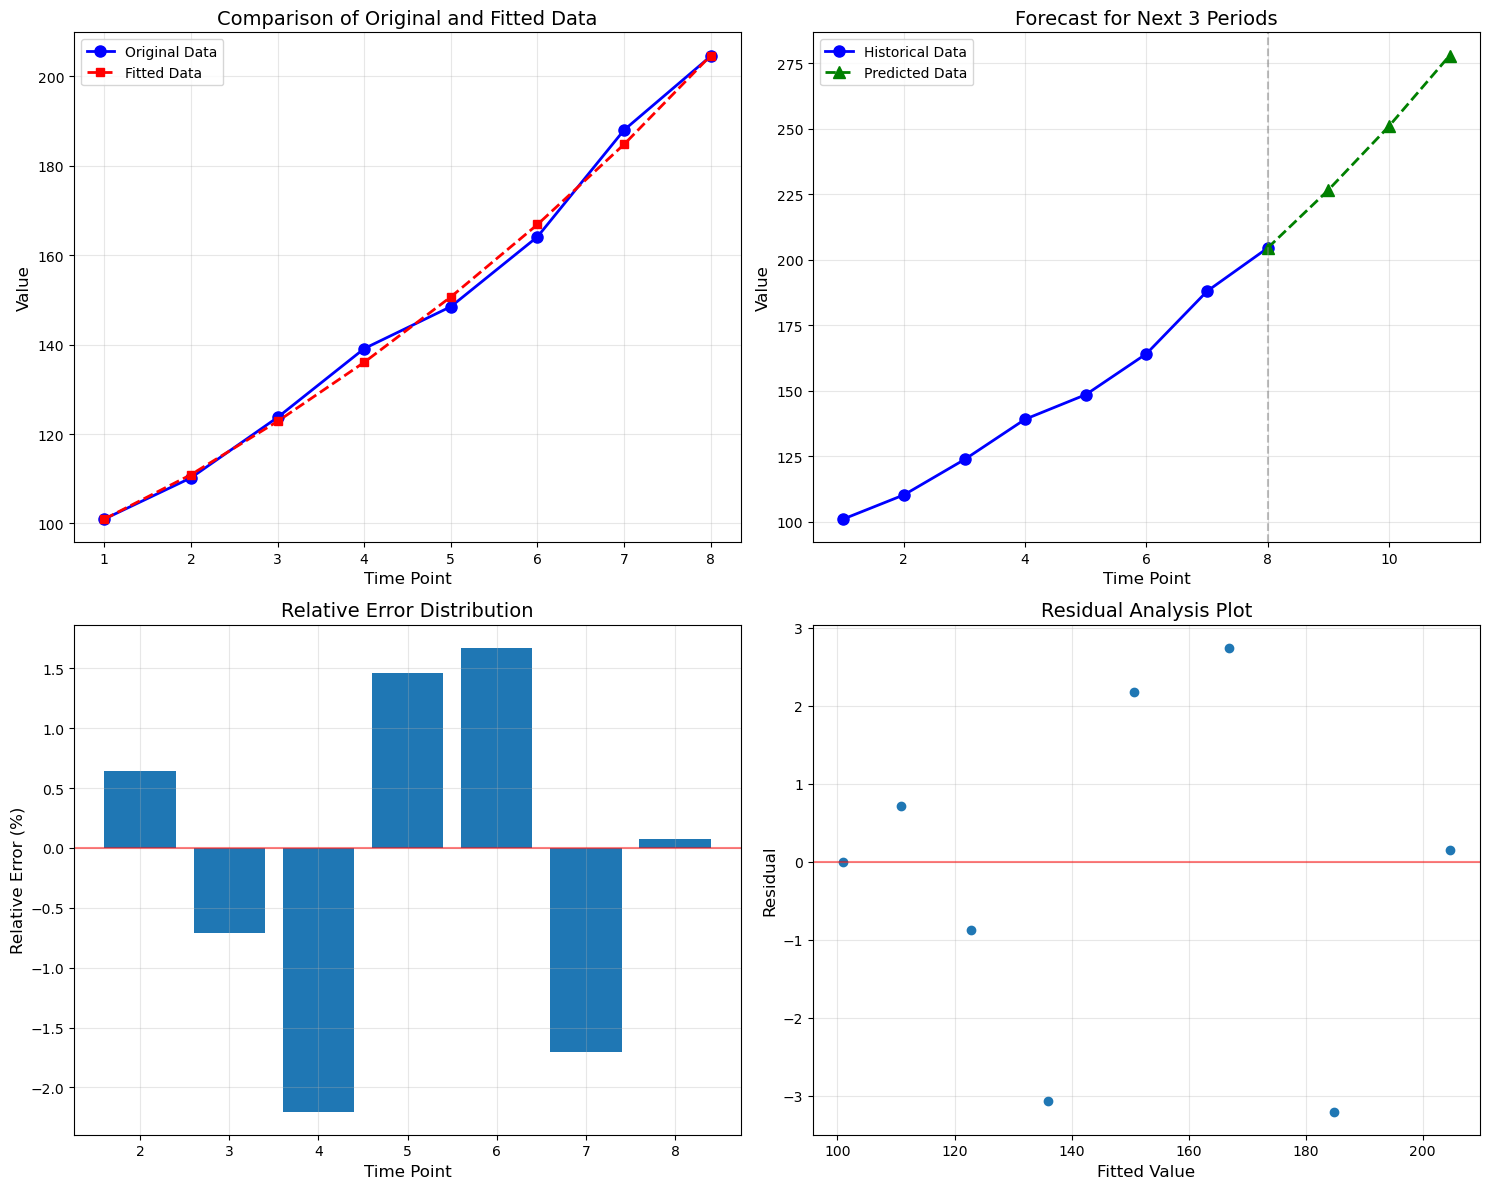


Example 2: Optimized Grey Model
Linear Trend Data: [100.25 109.93 120.32 130.76 139.88 149.88 160.79 170.38 179.77 190.27]
Optimized background value coefficient: 0.100
GM(1,1) Model Evaluation Report

1. Model Parameters:
 Development coefficient a = -0.067935
 Grey action quantity b = 106.095920

2. Error Indicators:
 Mean Absolute Percentage Error (MAPE) = 3.27%
 Root Mean Square Error (RMSE) = 5.7183
 Mean Absolute Error (MAE) = 4.9132

3. Prediction Capability Indicators:
 Posterior variance ratio C = 0.1019
 Small error probability P = 1.0000

4. Model Accuracy Level:
 Level: Good

Forecast for Next 4 Periods: [215.32268749 230.45903861 246.65941659 263.99861841]

Example 3: Multi-Scenario Model Comparison


In [28]:
# Example 1: Basic GM(1,1) model
print("=" * 60)
print("Example 1: Basic GM(1,1) Model")
print("=" * 60)
# Generate data
data_exp = generate_grey_data(n=8, trend_type='exponential', noise_level=0.02)
print(f"Original Data: {data_exp}")
# Create model
model1 = GreyModelGM11()
model1.fit(data_exp)
# Evaluate model
metrics1 = model1.evaluate()
# Perform prediction
predictions1 = model1.predict(steps=3)
print(f"\nForecast for Next 3 Periods: {predictions1}")
# Visualize
model1.plot_results(future_steps=3)
# Example 2: Optimized grey model
print("\n" + "=" * 60)
print("Example 2: Optimized Grey Model")
print("=" * 60)
# Generate data with different trend
data_linear = generate_grey_data(n=10, trend_type='linear', noise_level=0.05)
print(f"Linear Trend Data: {data_linear}")
# Use optimized model
model2 = OptimizedGreyModel(optimization_method='least_squares')
model2.fit(data_linear, optimize_background=True)
# Evaluate
metrics2 = model2.evaluate()
# Predict
predictions2 = model2.predict(steps=4)
print(f"\nForecast for Next 4 Periods: {predictions2}")
# Example 3: Multi-scenario comparison
print("\n" + "=" * 60)
print("Example 3: Multi-Scenario Model Comparison")
print("=" * 60)

GM(1,1) Model Evaluation Report

1. Model Parameters:
 Development coefficient a = -0.096286
 Grey action quantity b = 98.457845

2. Error Indicators:
 Mean Absolute Percentage Error (MAPE) = 1.71%
 Root Mean Square Error (RMSE) = 3.5161
 Mean Absolute Error (MAE) = 3.0376

3. Prediction Capability Indicators:
 Posterior variance ratio C = 0.0573
 Small error probability P = 1.0000

4. Model Accuracy Level:
 Level: Good
Optimized background value coefficient: 0.100
GM(1,1) Model Evaluation Report

1. Model Parameters:
 Development coefficient a = -0.100127
 Grey action quantity b = 102.416764

2. Error Indicators:
 Mean Absolute Percentage Error (MAPE) = 5.84%
 Root Mean Square Error (RMSE) = 13.9701
 Mean Absolute Error (MAE) = 11.6713

3. Prediction Capability Indicators:
 Posterior variance ratio C = 0.1252
 Small error probability P = 1.0000

4. Model Accuracy Level:
 Level: Good

Model Performance Comparison:
Model Type  MAPE(%)  Posterior Variance Ratio C  Small Error Probability

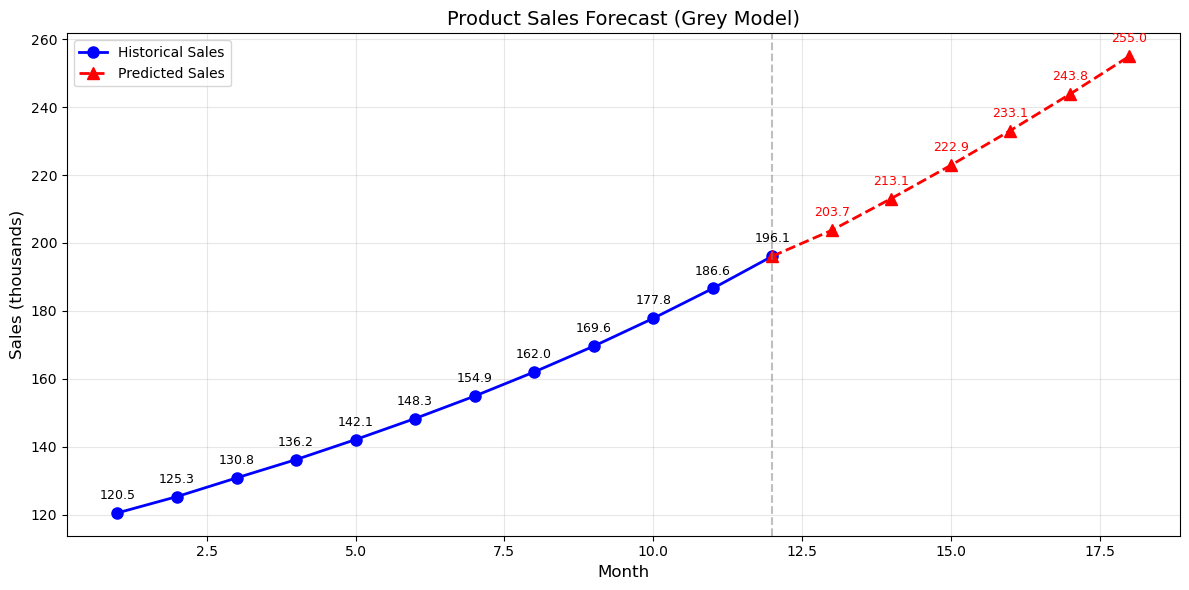


Example 5: Model Stability Test


In [29]:
# Test comparison
test_data = generate_grey_data(n=12, trend_type='exponential', noise_level=0.03)
results = compare_grey_models(test_data)
# Example 4: Practical application simulation - Sales forecast
print("\n" + "=" * 60)
print("Example 4: Practical Application - Product Sales Forecast")
print("=" * 60)
# Simulate monthly sales data for a product (unit: thousands)
monthly_sales = np.array([
    120.5, 125.3, 130.8, 136.2, 142.1, 148.3,
    154.9, 162.0, 169.6, 177.8, 186.6, 196.1
])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
print(f"Past 12 Months Sales Data (thousands):")
for month, sales in zip(months, monthly_sales):
    print(f" {month}: {sales:.1f}")
# Use optimized grey model
sales_model = OptimizedGreyModel()
sales_model.fit(monthly_sales)
# Evaluate
sales_metrics = sales_model.evaluate()
# Forecast next 6 months
future_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
future_predictions = sales_model.predict(steps=6)
print(f"\nSales Forecast for Next 6 Months (thousands):")
for month, pred in zip(future_months, future_predictions):
    print(f" {month}: {pred:.1f}")
# Calculate growth rate
growth_rates = []
for i in range(1, len(monthly_sales)):
    rate = (monthly_sales[i] - monthly_sales[i-1]) / monthly_sales[i-1] * 100
    growth_rates.append(rate)
avg_growth = np.mean(growth_rates)
print(f"\nHistorical Average Monthly Growth Rate: {avg_growth:.2f}%")
# Visualize sales forecast
plt.figure(figsize=(12, 6))
# Historical data
plt.plot(range(1, 13), monthly_sales, 'bo-', linewidth=2, markersize=8, label='Historical Sales')
# Predicted data
plt.plot(range(12, 19), [monthly_sales[-1]] + list(future_predictions[:6]),
         'r^--', linewidth=2, markersize=8, label='Predicted Sales')
plt.axvline(x=12, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales (thousands)', fontsize=12)
plt.title('Product Sales Forecast (Grey Model)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
# Add value labels
for i, (x, y) in enumerate(zip(range(1, 13), monthly_sales)):
    plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points",
                 xytext=(0,10), ha='center', fontsize=9)
for i, (x, y) in enumerate(zip(range(12, 19), [monthly_sales[-1]] + list(future_predictions[:6]))):
    if i > 0: # Skip the last point of historical data
        plt.annotate(f'{y:.1f}', (x, y), textcoords="offset points",
                     xytext=(0,10), ha='center', fontsize=9, color='red')
plt.tight_layout()
plt.show()
# Example 5: Model validation and stability test
print("\n" + "=" * 60)
print("Example 5: Model Stability Test")
print("=" * 60)

Stability Test Results (50 simulations):
 MAPE Average: 12.16%
 MAPE Standard Deviation: 4.77%
 Posterior Variance Ratio C Average: 0.8310
 Small Error Probability P Average: 0.6050


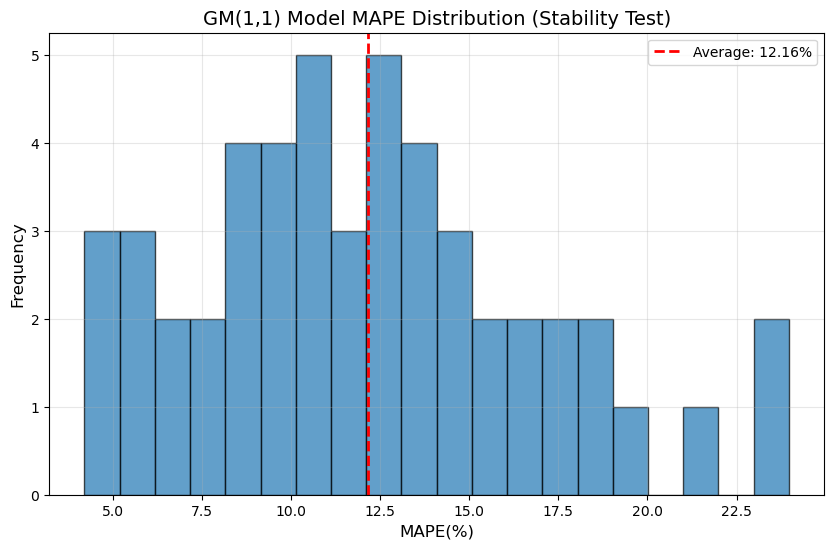

In [30]:
# Run stability test
stability_test(GreyModelGM11, n_simulations=50, data_length=8)